<a href="https://colab.research.google.com/github/WestChaeVI/Data-Network-Analysis/blob/main/CV_seminar_week4_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
pwd

'/content/drive/MyDrive/CV_seminar_project'

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [51]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [52]:
device

'cuda'

In [53]:
root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
test_path = '/content/drive/MyDrive/CV_seminar_project/test'

# pytorch 데이터셋 클래스 실습

### 1. 파이토치 데이터 셋 클래스를 직접 만들어보자.

파이토치 데이터 셋 클래스는 init, getitem, len 특수 메소드 3개를 요구한다.   
 항상 같은 포맷을 만드는 습관이 중요하다. 
> 따라서 root_path, mode(train or validation or test), transform(전처리&Augmentation) 3개의 입력을 받아 data와 label을 출력하는 클래스를 만들도록하자.


In [54]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os 

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms):
    self.all_data = sorted( glob.glob( os.path.join(root_path, mode, '*', '*') ) ) # 전체 경로
    self.transforms = transforms

  def __getitem__(self, index):
    if torch.is_tensor(index): # 인덱스가 tensor형태일 수 있는 것을 방지
      index = index.tolist()

    data_path = self.all_data[index] # 인덱스가 부여된 데이터 1개
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 라이브러리의 BGR 형식을 RGB로 permute

    # transfrom 적용
    if self.transforms is not None:
      augmentation = self.transforms(image = image)
      image = augmentation['image']

    # 이미지의 이름을 이용하여, label 부여하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

### 2. 전처리와 Augmentation을 적용한다.
> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> 텐서화: 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.


In [55]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

# week4 과제
아래와 같이 원래 0~255 픽셀 값을 가진 귀여운 돌고래 이미지는 Augmentation이 적용되어(train_class[0][0]) 이미지가 변형 되었다.   
**train_class[0][0] 데이터**를 시각화 할 수 있도록 시각화 라이브러리가 요구하는 numpy 타입의 올바른 이미지 데이터로 되돌리는 역함수를 만들어 시각화 해오는 것.   

결과물에 대해서는 week4 pdf의 과제 설명에 있는 이미지를 보시면 이해될 것입니다.

In [9]:
train_class.all_data[0]

'/content/drive/MyDrive/CV_seminar_project/train/dolphin/dolphin_000.jpg'

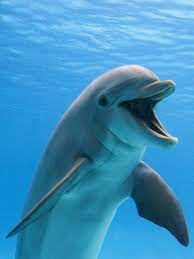

In [14]:
from PIL import Image as PILImage
import numpy as np
PILImage.open(train_class.all_data[0]) # augmentation이 적용되지 않은 사진

In [11]:
train_class[0][0] # 역함수를 이용해 이것을 시각화 해주세요.

tensor([[[ 0.7419,  0.7419,  0.6221,  ..., -0.7822, -0.9192, -1.0219],
         [ 0.6221,  0.6221,  0.6906,  ..., -0.4739, -0.6452, -0.7479],
         [ 0.6392,  0.6392,  0.7419,  ..., -0.5424, -0.7137, -0.8164],
         ...,
         [-1.1589, -1.1760, -1.1932,  ..., -1.6555, -1.6384, -1.6384],
         [-1.1589, -1.1589, -1.1760,  ..., -1.6213, -1.5870, -1.5870],
         [-1.1418, -1.1418, -1.1760,  ..., -1.6042, -1.5870, -1.5870]],

        [[ 1.8333,  1.8333,  1.7633,  ...,  0.9055,  0.7829,  0.6604],
         [ 1.7458,  1.7633,  1.8333,  ...,  1.2206,  1.0805,  0.9405],
         [ 1.8333,  1.8333,  1.9384,  ...,  1.2031,  1.0805,  0.9230],
         ...,
         [ 0.9405,  0.9405,  0.9230,  ...,  0.7304,  0.7479,  0.7479],
         [ 0.9055,  0.8880,  0.9230,  ...,  0.7479,  0.7479,  0.7479],
         [ 0.9055,  0.8880,  0.9230,  ...,  0.7479,  0.7479,  0.7479]],

        [[ 2.5354,  2.5180,  2.3786,  ...,  2.0300,  1.8905,  1.7685],
         [ 2.5006,  2.4483,  2.5180,  ...,  2

In [100]:
def converter(augmentationed_image):  # augmentationed_image = train_class[i][0]

  ### 역함수 로직을 짜주세요. ###
  perimg = augmentationed_image.permute(1,2,0) # shape (224,224, 3) H,W,C 로 바꾸기
  perimg_tonumpy = perimg.numpy() # tensor -> numpy / broadcasting을 위해서

  # img = (img - mean * max_pixel_value) / (std * max_pixel_value)
  m = np.array([[[0.485, 0.456, 0.406]]])
  s = np.array([[[0.229, 0.224, 0.225]]])
  converted_image = ((perimg_tonumpy * s * 255.0) + (m * 255.0)).astype(int) # std 곱하고 mean 더하기

  return converted_image

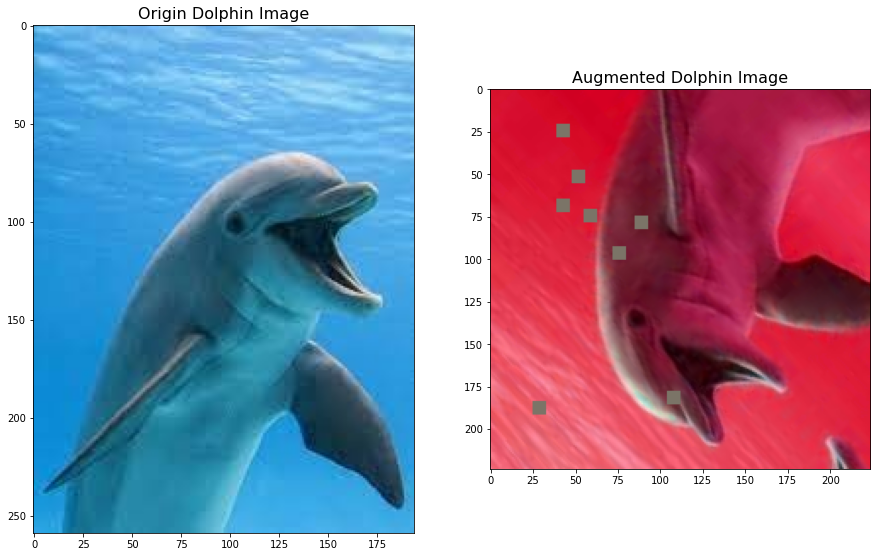

In [152]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))
plt = fig.subplots(1,2)

img = cv2.imread(train_class.all_data[0])[:,:,::-1]
plt[0].imshow(img)
plt[0].set_title('Origin Dolphin Image', fontsize= 16)
plt[1].imshow(converter(train_class[0][0]))
_=plt[1].set_title('Augmented Dolphin Image', fontsize= 16)

완쪽에는 귀여운 돌고래 원본이미지가, 오른쪽에는 Augmentation이 적용된 돌고래 이미지가 만들어졌습니다.